# 9. 집 값 예측

In [1]:
# 프로젝트를 진행하기 전에, 몇 가지 작업이 필요하다
# 필요한 라이브러리를 import 하고 데이터를 가져온다
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [2]:
# 가져온 데이터를 확인해보자
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [3]:
# date 부분을 전처리 해준다. int, 즉 정수형 데이터로 바꾼다. 그러면 date도 예측을 위한 특성으로 활용이 가능하다.
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [4]:
# y변수에 price를 넣어주고, train에서는 삭제한다
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
# 마지막 전처리로 id 컬럼을 삭제해준다
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# test 데이터에도 동일하게 전처리 작업을 진행해보자
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

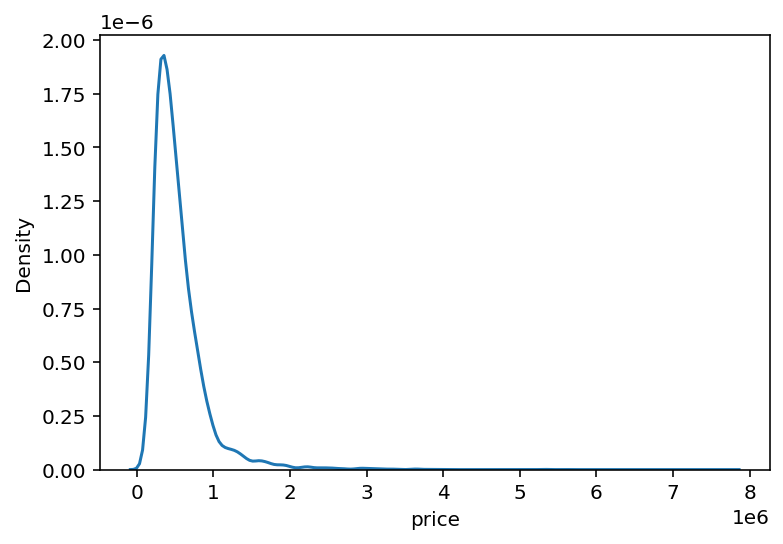

In [8]:
# y변수(price)에 들어있는 값을 보다시피, 아주 큰 값들로 이루어져 있다. 가격 데이터의 분포도를 한번 확인해 보자.
sns.kdeplot(y)
plt.show()

In [9]:
# 왼쪽으로 크게 치우쳐 있는 형태를 보인다. 따라서 np.loglp() 함수를 통해 로그 변환을 해주고,
# 나중에 모델이 값을 예측한 후에 다시 np.explm()을 활용해서 되돌리겠다.
# np.explm()은 np.loglp()와는 반대로 각 원소 x마다, exp(x)-1의 값을 반환해 준다.
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

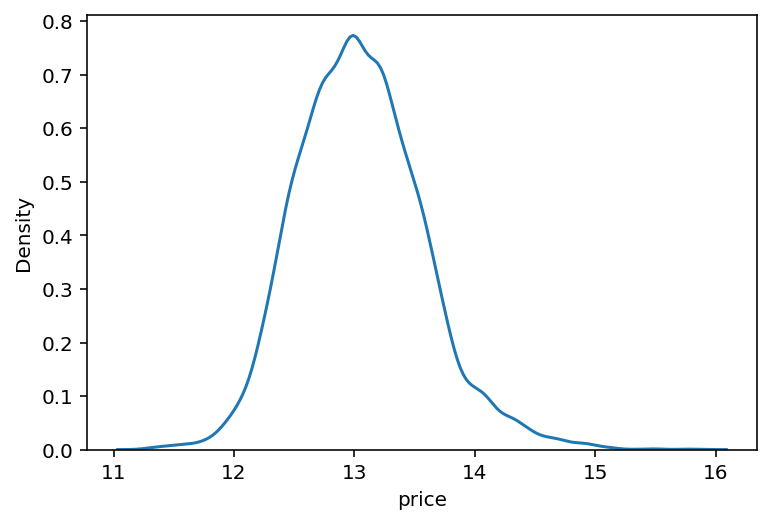

In [10]:
sns.kdeplot(y)
plt.show()

In [11]:
# 비교적 완만한 정규분포의 형태로 변환되었으니, info()함수로 전체 데이터의 자료형을 확인해보자
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [12]:
# 이제 모델 튜닝을 해볼건데, 먼저 RMSE를 계산해보려고 한다.
# 데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 train_test_split 함수와,
# RMSE 점수를 계산하기 위한 mean_squared_error를 가져온다.
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [13]:
# 대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 만들어보겠다.
# 한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점이다.
# exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있다.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [14]:
# 필요한 라이브러를 import 한다
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

아래와 같이 모델 인스턴스를 생성한 후 models라는 리스트에 넣어준다

이때, 모델 파라미터 초기화나 데이터셋 구성에 사용되는 랜덤 시드값인 random_state 값을 특정 값으로 고정시키거나, 아니면 지정하지 않고 None으로 세팅할 수 있다. random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현된다. 하지만 이 값을 지정하지 않고 None으로 남겨 두면 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라진다.

앞으로 우리는 베이스라인에서부터 시작해서 다양한 실험을 통해 성능이 개선되는지를 검증해 보려고 한다. 이때, 어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해서는 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 한다. 따라서 아래와 같이 random_state 값을 특정 값으로 고정시킬 것이다. 혹시 고정하지 않았을 때 어떤 상황이 벌어지는지 궁금하다면 random_state 값을 None으로 남겨두고 실험을 반복해 봐도 된다.

In [15]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값이다
#random_state=None    # 초기값이다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택한다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [16]:
# 각 모델의 이름은 다음과 같이 클래스의 __name__ 속성에 접근해서 얻을 수 있다
gboost.__class__.__name__

'GradientBoostingRegressor'

In [17]:
# 이름을 접근할 수 있다면, 다음과 같이 for문 안에서 각 모델 별로 학습 및 예측을 해볼 수 있다
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [18]:
# 위의 과정을 get_scores(models, train, y) 함수로 만들어 보겠다
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [19]:
# 이제 모델과 데이터셋이 있다면 RMSE 결괏값을 나타내주는 함수가 준비되었으니, 다양한 하이퍼 파라미터로 실험하는 일만 남았다.
# 실험은 skleran.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용한다.
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


In [20]:
# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비한다
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    'max_depth': [5, 50, 200, 500, 1000],
}

In [21]:
# 그 다음으로 모델을 준비한다. 모델은 LightGBM을 사용하겠다
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [22]:
# 다음과 같이 GridSearchCV를 이용해서 grid_model모델을 초기화하고, train과 y데이터로 모델을 간단히 학습시키면,
# param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료된다.
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   17.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   59.1s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 1050 out of 1050 | elapsed:  2.8min finished


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [5, 50, 200, 500, 1000],
                         'n_estimators': [50, 100, 200, 300, 500, 1000],
                         'num_leaves': [5, 8, 16, 24, 32, 64, 128]},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
# 결과를 살펴보자
grid_model.cv_results_

{'mean_fit_time': array([0.12301793, 0.10889215, 0.12471175, 0.12304544, 0.11775827,
        0.10774436, 0.10145745, 0.09594059, 0.15000706, 0.16450696,
        0.17921848, 0.18329258, 0.2018837 , 0.20091734, 0.21601205,
        0.23379512, 0.36910243, 0.37671614, 0.33156128, 0.30695   ,
        0.38915253, 0.30221581, 0.36274447, 0.34019985, 0.38776774,
        0.49435625, 0.47434773, 0.48827105, 0.41631517, 0.46001415,
        0.60470943, 0.77329016, 0.6571631 , 0.70248055, 0.62015133,
        0.76895795, 0.9775022 , 1.43552837, 1.6263618 , 1.69373536,
        1.31103568, 1.48822141, 0.08513098, 0.07989268, 0.12302871,
        0.13999963, 0.19476495, 0.22673564, 0.34134455, 0.15813994,
        0.21934528, 0.25580688, 0.27740402, 0.33349724, 0.41124973,
        0.69260154, 0.21049438, 0.20527821, 0.33301549, 0.42079749,
        0.47860847, 0.67132587, 1.19841876, 0.25515904, 0.3078784 ,
        0.40063128, 0.49011383, 0.56638713, 0.91278458, 1.52507124,
        0.380056  , 0.36688275,

In [24]:
# 정보가 너무 많으니까, 원하는 값만 정제해서 확인해보겠다
params = grid_model.cv_results_['params']
params

[{'max_depth': 5, 'n_estimators': 50, 'num_leaves': 5},
 {'max_depth': 5, 'n_estimators': 50, 'num_leaves': 8},
 {'max_depth': 5, 'n_estimators': 50, 'num_leaves': 16},
 {'max_depth': 5, 'n_estimators': 50, 'num_leaves': 24},
 {'max_depth': 5, 'n_estimators': 50, 'num_leaves': 32},
 {'max_depth': 5, 'n_estimators': 50, 'num_leaves': 64},
 {'max_depth': 5, 'n_estimators': 50, 'num_leaves': 128},
 {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 5},
 {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 8},
 {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 16},
 {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 24},
 {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 32},
 {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 64},
 {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 128},
 {'max_depth': 5, 'n_estimators': 200, 'num_leaves': 5},
 {'max_depth': 5, 'n_estimators': 200, 'num_leaves': 8},
 {'max_depth': 5, 'n_estimators': 200, 'num_leaves': 16},
 {'max_depth': 5, 'n_esti

In [25]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.04327449, -0.03707173, -0.03286797, -0.03185909, -0.03169436,
       -0.03169436, -0.03169436, -0.03496472, -0.03145068, -0.02898733,
       -0.02873564, -0.02867938, -0.02867938, -0.02867938, -0.03089204,
       -0.02875965, -0.02712336, -0.0269831 , -0.02714909, -0.02714909,
       -0.02714909, -0.02914625, -0.02776614, -0.0265295 , -0.02651515,
       -0.02672529, -0.02672529, -0.02672529, -0.02753008, -0.02676605,
       -0.02623824, -0.02636093, -0.02654036, -0.02654036, -0.02654036,
       -0.02635069, -0.02607216, -0.02629624, -0.02679518, -0.0269612 ,
       -0.0269612 , -0.0269612 , -0.04327449, -0.03671845, -0.0315605 ,
       -0.03004234, -0.02918852, -0.02787668, -0.02805595, -0.03496472,
       -0.03115979, -0.02802331, -0.02742353, -0.02703817, -0.02675366,
       -0.02739547, -0.03089204, -0.02862239, -0.02671804, -0.02646315,
       -0.02636515, -0.02653726, -0.02761289, -0.02914625, -0.02767702,
       -0.02613917, -0.02625965, -0.02624652, -0.02663256, -0.02

In [26]:
# params에는 각 파라미터의 조합이, score에는 각 조합에 대한 점수가 들어가 있다.
# 이제 이 둘만 가지고 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아보자.
results = pd.DataFrame(params)
results['score'] = score

results

max_depth  n_estimators  num_leaves     score
0            5            50           5 -0.043274
1            5            50           8 -0.037072
2            5            50          16 -0.032868
3            5            50          24 -0.031859
4            5            50          32 -0.031694
..         ...           ...         ...       ...
205       1000          1000          16 -0.026088
206       1000          1000          24 -0.026733
207       1000          1000          32 -0.026884
208       1000          1000          64 -0.027497
209       1000          1000         128 -0.028353

[210 rows x 4 columns]

In [27]:
# 아래와 같은 변환 함수로 RMSE 점수를 볼 수 있도록 하겠다. 음수로 된 MSE였으니, -1을 곱해주고 np,sqrt로 루트 연산을 해주면 된다
results['RMSE'] = np.sqrt(-1 * results['score'])
results

max_depth  n_estimators  num_leaves     score      RMSE
0            5            50           5 -0.043274  0.208025
1            5            50           8 -0.037072  0.192540
2            5            50          16 -0.032868  0.181295
3            5            50          24 -0.031859  0.178491
4            5            50          32 -0.031694  0.178029
..         ...           ...         ...       ...       ...
205       1000          1000          16 -0.026088  0.161517
206       1000          1000          24 -0.026733  0.163502
207       1000          1000          32 -0.026884  0.163962
208       1000          1000          64 -0.027497  0.165821
209       1000          1000         128 -0.028353  0.168384

[210 rows x 5 columns]

아직도 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것 같다.

그 이유는 price에 있다. 위에서 우리는 price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했다.
그 후 rmse 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했다.

하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한 것이다.
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 이다.
log를 취한 값에서 RMSE를 구했다는 뜻이다.

이에 맞게 컬럼의 이름을 RMSLE로 변환해 주도록 한다. 판다스에서 컬럼의 이름 변환은 rename으로 할 수 있다.

In [28]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

max_depth  n_estimators  num_leaves     score     RMSLE
0            5            50           5 -0.043274  0.208025
1            5            50           8 -0.037072  0.192540
2            5            50          16 -0.032868  0.181295
3            5            50          24 -0.031859  0.178491
4            5            50          32 -0.031694  0.178029
..         ...           ...         ...       ...       ...
205       1000          1000          16 -0.026088  0.161517
206       1000          1000          24 -0.026733  0.163502
207       1000          1000          32 -0.026884  0.163962
208       1000          1000          64 -0.027497  0.165821
209       1000          1000         128 -0.028353  0.168384

[210 rows x 5 columns]

In [29]:
# RMSLE가 낮은 순서대로 정렬한다. sort_values로 간단히 할 수 있다
results = results.sort_values('RMSLE')
results

max_depth  n_estimators  num_leaves     score     RMSLE
156        500           500          16 -0.025958  0.161115
72          50           500          16 -0.025958  0.161115
198       1000           500          16 -0.025958  0.161115
114        200           500          16 -0.025958  0.161115
204       1000          1000           8 -0.026031  0.161341
..         ...           ...         ...       ...       ...
84         200            50           5 -0.043274  0.208025
168       1000            50           5 -0.043274  0.208025
42          50            50           5 -0.043274  0.208025
126        500            50           5 -0.043274  0.208025
0            5            50           5 -0.043274  0.208025

[210 rows x 5 columns]

In [30]:
# 지금까지의 과정을 하나의 함수로 만들어 보겠다

"""
1. GridSearchCV 모델로 `model`을 초기화
2. 모델을 fitting
3. params, score에 각 조합에 대한 결과를 저장
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [32]:
# 실험을 통해 좋은 결과를 내는 모델을 찾았다면 kaggle에 제출을 해야할 것이다. 제출 과정 또한 하나의 함수로 깔끔하게 진행하겠다
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 50, 200, 300]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  52 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:    5.7s finished


max_depth  n_estimators     score     RMSLE
7          50           300 -0.026091  0.161527
11        200           300 -0.026091  0.161527
15        300           300 -0.026091  0.161527
6          50           200 -0.026245  0.162003
10        200           200 -0.026245  0.162003
14        300           200 -0.026245  0.162003
3           5           300 -0.026606  0.163112
5          50           100 -0.027051  0.164472
9         200           100 -0.027051  0.164472
13        300           100 -0.027051  0.164472
2           5           200 -0.027160  0.164803
1           5           100 -0.028797  0.169696
4          50            50 -0.029198  0.170875
8         200            50 -0.029198  0.170875
12        300            50 -0.029198  0.170875
0           5            50 -0.031783  0.178277

In [33]:
# 가장 좋은 조합은 max_depth=10, n_estimators=100 이다. 해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출해보겠다.
# 먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성한다.
model = LGBMRegressor(max_depth=300, n_estimators=300, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12160458, 13.10226918, 14.15043868, ..., 13.05037436,
       12.67158278, 13.01735592])

In [34]:
# 예측 결과에 np.expml()을 씌워서 다시 원래 스케일로 되돌린다
prediction = np.expm1(prediction)
prediction

array([ 499619.74521686,  490052.17258291, 1397838.90879818, ...,
        465269.55869982,  318564.30877008,  450157.90324192])

In [35]:
# sample_submission.csv 파일을 가져와보겠다
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [36]:
# 위의 데이터프레임에 우리의 모델이 예측한 값을 덮어씌우면 제출할 데이터가 완성된다
submission['price'] = prediction
submission.head()

id         price
0  15035  4.996197e+05
1  15036  4.900522e+05
2  15037  1.397839e+06
3  15038  3.072446e+05
4  15039  3.279127e+05

In [37]:
# 위의 데이터를 csv 파일로 저장한다.
# 단, 앞으로는 많은 실험이 있을 예정이니 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리될 것이다.
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', 'Test3')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/ssac3/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_Test3.csv


In [38]:
# 위의 과정들을 하나의 함수로 만들어두겠다
"""
1. 모델을 `train`, `y`로 학습
2. `test`에 대해 예측
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [39]:
# 위의 함수를 사용한다면, 다음 한줄로 모델을 학습시킨 후 예측 결과를 저장 할 수 있다
save_submission(model, train, y, test, 'lgbm', rmsle='Test2')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/home/ssac3/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_Test4.csv saved!


![result](image/result.png)